In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
np.set_printoptions(threshold=np.inf)
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
# Full dataset location: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data
# Train dataset was split randomly in train - test - validation 
# Paths 
all_data = "Data"
train_folder = 'train'
val_foder ='val'
test_folder = 'test'

# Annotation file
train_annotation = pd.read_csv(os.path.join(all_data, "Training_set.csv"))
val_annotation = pd.read_csv(os.path.join(all_data, "Validation_set.csv"))
test_annotation = pd.read_csv(os.path.join(all_data, "Testing_set.csv"))

### Check first 6 images in the train set

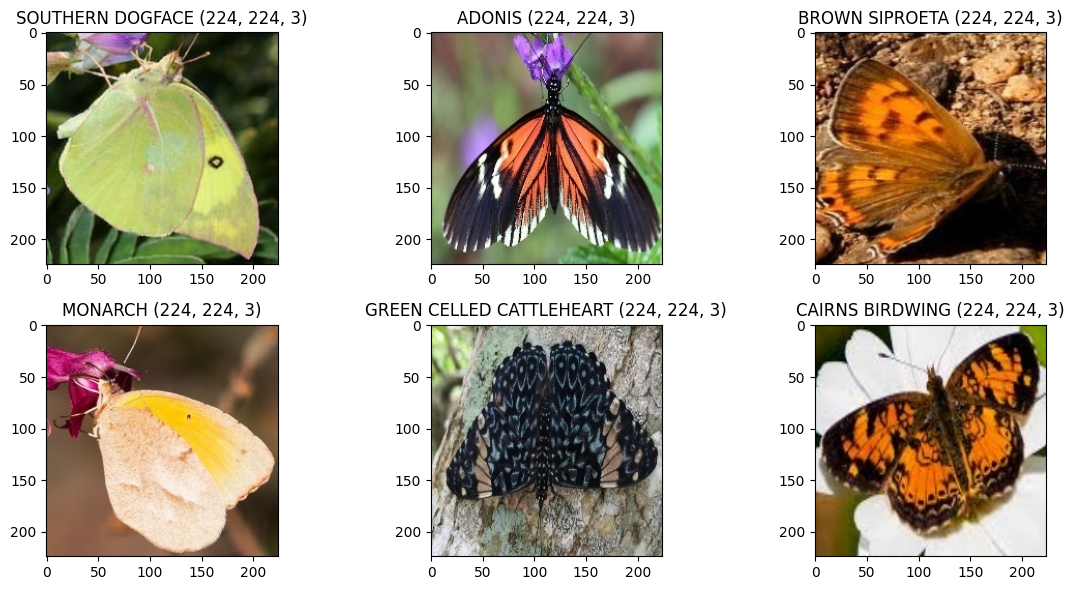

In [ ]:
# Train images path
images = [ os.path.join( all_data, train_folder, i ) for i in os.listdir(os.path.join(all_data, train_folder))] 

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    img = plt.imread(images[i])
    plt.imshow(img)
    plt.title(train_annotation.iloc[i]['label'] + ' '+ str(img.shape))
plt.tight_layout()
plt.show()

### Annotation files

In [4]:
display(train_annotation.head())
classes = train_annotation['label'].unique().tolist()
n_classes = len(classes)
print("number of classes: ", n_classes)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


number of classes:  75


In [5]:
# Fit an encoder for categorical variable, to be used to transform the label inside the torch dataset
from sklearn.preprocessing import OneHotEncoder
y_train = train_annotation[['label']]
ohe = OneHotEncoder( sparse_output=False).fit(y_train)
ohe

OneHotEncoder(sparse_output=False)

# Create torch dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom dataset class
class ButterflyImageDataset(Dataset):
    def __init__(self, 
                 annotations_file,               # image --> class mapping file        
                 img_dir,                        # images directory 
                 transform=None,                 # how to preprocess / transform the images  
                 target_transform=None):         # how to preprocess / transform the class of the images   
        
        self.img_labels = pd.read_csv(annotations_file)  
        self.img_dir = img_dir                           
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):  # return the number of images in the dataset
        return len(self.img_labels)

    def __getitem__(self, idx):   # to retrieve an image and its label given the index 
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = plt.imread(img_path)
        label = np.array([[self.img_labels.iloc[idx,1]]])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = torch.tensor(self.target_transform.transform(label))
        return image, label
    

# Train set transformation:
# Transform image to a tensor, apply random image modification and normalize the tensor with a mean (0,0,0) and standard deviation (0.5,0.5,0.5) for each channel
image_transformation_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
     transforms.RandomHorizontalFlip(),  # Random horizontal flip
     transforms.RandomRotation(180),      # Random rotation between -180 to +180 degrees
     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Validation and test sets transformation:
# Transform image to a tensor, apply random image modification and normalize the tensor with a mean (0,0,0) and standard deviation (0.5,0.5,0.5) for each channel
image_transformation_val_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
# Create datasets and dataloaders 
batch_size = 164
# Training set
train_butterly = ButterflyImageDataset(annotations_file= os.path.join(all_data, "Training_set.csv"),
                                        img_dir = os.path.join(all_data, train_folder),
                                        transform=image_transformation_train,
                                        target_transform = ohe)  

train_butterly_dataloader = DataLoader(train_butterly, 
                                       batch_size= batch_size,
                                       shuffle=True, 
                                       num_workers=0,
                                       drop_last = True)

# Validation set
val_butterly = ButterflyImageDataset(annotations_file= os.path.join(all_data, "Validation_set.csv"),
                                     img_dir = os.path.join(all_data, val_foder),
                                     transform=image_transformation_val_test,
                                     target_transform = ohe)  

val_butterly_dataloader = DataLoader(val_butterly, 
                                     batch_size= batch_size,
                                     shuffle=False, 
                                     num_workers=0,
                                     drop_last = True)

# Test set
test_butterly = ButterflyImageDataset(annotations_file= os.path.join(all_data, "Testing_set.csv"),
                                      img_dir = os.path.join(all_data, test_folder),
                                      transform = image_transformation_val_test,
                                      target_transform = ohe)  

test_butterly_dataloader = DataLoader(test_butterly, 
                                      batch_size= batch_size,
                                      shuffle=False, 
                                      num_workers=0)


# Create Torch CNN classifier model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Create the pytorch classifier class
class ButterflyClassifier(nn.Module):
    def __init__(self):
        super(ButterflyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5)    # in_channels, out_channels, kernel_size
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(96, 156, 3)  # in_channels, out_channels, kernel_size
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(156, 182, 3)  # in_channels, out_channels, kernel_size
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(182 * 26*26, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 182 * 26*26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print('out shape')
        #print(x.size())
        return x

# Training

In [10]:
# Instantiate the model
butterflyclassifier = ButterflyClassifier()

# Specify the optimizer
import torch.optim as optim
optimizer = optim.SGD(butterflyclassifier.parameters(), lr=0.02, momentum=0.9)

# Specify the loss
criterion = nn.CrossEntropyLoss()

# Select GPU as device
device = torch.device('cuda')

-------- Epoch 1 --------
Train loss: 0.0263
Validation loss: 0.0263
Epochs with no improvement: 0
-------- Epoch 2 --------
Train loss: 0.026
Validation loss: 0.0253
Epochs with no improvement: 0
-------- Epoch 3 --------
Train loss: 0.0244
Validation loss: 0.0227
Epochs with no improvement: 0
-------- Epoch 4 --------
Train loss: 0.0231
Validation loss: 0.0221
Epochs with no improvement: 0
-------- Epoch 5 --------
Train loss: 0.0225
Validation loss: 0.0215
Epochs with no improvement: 0
-------- Epoch 6 --------
Train loss: 0.022
Validation loss: 0.0216
Epochs with no improvement: 1
-------- Epoch 7 --------
Train loss: 0.0215
Validation loss: 0.0204
Epochs with no improvement: 0
-------- Epoch 8 --------
Train loss: 0.0209
Validation loss: 0.0202
Epochs with no improvement: 1
-------- Epoch 9 --------
Train loss: 0.0206
Validation loss: 0.0197
Epochs with no improvement: 0
-------- Epoch 10 --------
Train loss: 0.0201
Validation loss: 0.0207
Epochs with no improvement: 1
-------- Ep

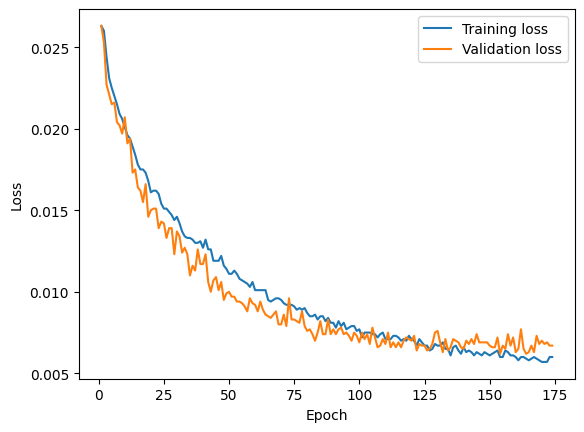

In [11]:
# function to train the model
def train(model, 
          device, 
          epochs, 
          patience,  # for early stopping: how many epochs the training process should continue after the last improvement on validation set before stopping
          delta): # minimum percentage change in validation loss that qualifies as an improvement.
    

    model.to(device)
    train_loss, val_loss = [], []

    delta_count = 0 # counter the keeps track of how many epochs the validation loss did not improve
    baseline_val_loss = 100000  # starting value of the loss on the validation set. Set initially to a very big value. It is updated at each epoch afterwards 

    # loop over train and validation sets epochs times
    for e in range(epochs):  
        print(f"-------- Epoch {e + 1} --------")
        model.train()
        train_running_loss = 0.0
        sample_train = 0
        for i, data in enumerate(train_butterly_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.squeeze().to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

            sample_train += labels.size()[0]
        
        train_running_loss = round(train_running_loss   / sample_train , 4)
        train_loss.append(train_running_loss )
        print("Train loss:", train_running_loss)

        # Evaluate the model on the validation set
        model.eval()
        val_running_loss = 0.0
        sample_val = 0
        for _, data in enumerate(val_butterly_dataloader):
            
            inputs, labels = data
            inputs =  inputs.to(device)
            labels = labels.squeeze().to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            sample_val += labels.size()[0]
        
        val_running_loss = round(val_running_loss / sample_val, 4) 
        print("Validation loss:",val_running_loss)

        # Check if validation losses improved of at least delta %
        if (val_running_loss < baseline_val_loss) and (( baseline_val_loss  - val_running_loss ) / baseline_val_loss ) > delta:
            delta_count = 0
            baseline_val_loss = val_running_loss
        else:
            delta_count += 1
            if delta_count == 1 : 
                baseline_val_loss = val_running_loss

        val_loss.append(val_running_loss  )
        
        print(f"Epochs with no improvement: {delta_count}")
        
        if delta_count == patience:
            break

    # Plot losses
    plt.plot(range(1,len(train_loss) +1 ),train_loss, label = 'Training loss' )
    plt.plot(range(1, len(val_loss) +1 ),val_loss, label = 'Validation loss' )
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return model, train_loss, val_loss

# Train the model
model_trained, train_loss, val_loss = train(model = butterflyclassifier, 
                                            device = device, 
                                            epochs = 200, 
                                            patience = 10, 
                                            delta = 0.01) # 1 percent improve

                                            

In [ ]:
# Function to predict the class of images 
def make_prediction(model, 
                    device, 
                    dataloader):
    model.to(device)
    preds,truevalues  = [] , []

    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)
        outputs = model(inputs)

        preds.append(outputs.cpu().detach().numpy())
        truevalues.append(labels.cpu().detach().numpy())
        
    return np.concatenate(truevalues,axis =0) , np.concatenate(preds,axis =0)

# Function to calculate accuracy of the predicitions
def calculate_accuracy(true, preds):
    true_class = np.argmax(true, axis = 1)
    preds_class = np.argmax(preds, axis = 1)
    return  round( np.sum(true_class == preds_class )   / true_class.shape[0] , 3)

    
## ------- Calculate prediction accuracy on all 3 sets  -------
# Train set
train_pred = make_prediction(model= model_trained, 
                           device= device, 
                           dataloader = train_butterly_dataloader)
print(f'Train set accuracy {calculate_accuracy(train_pred[0], train_pred[1]) }')


# Validation set
val_pred = make_prediction(model= model_trained, 
                           device= device, 
                           dataloader = val_butterly_dataloader)
print(f'Validation set accuracy {calculate_accuracy(val_pred[0], val_pred[1])}')


# Test set
test_pred = make_prediction(model= model_trained, 
                           device= device, 
                           dataloader = test_butterly_dataloader)
print(f'Test set accuracy {calculate_accuracy(test_pred[0], test_pred[1])}')


Train set accuracy 0.721
Validation set accuracy 0.71
Test set accuracy 0.723


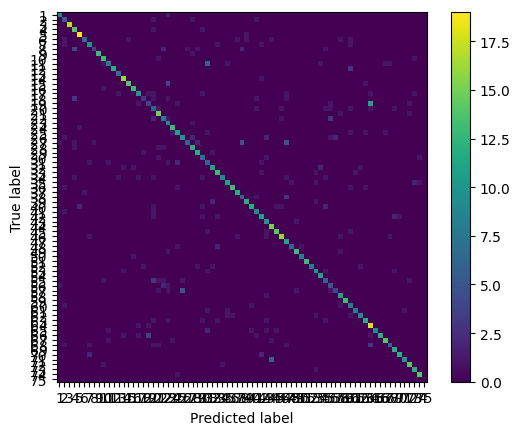

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y, preds):
    true_class = np.argmax(y, axis = 1)
    preds_class = np.argmax(preds, axis = 1)
    cm = confusion_matrix(true_class, preds_class,  labels= np.arange(1,76))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= np.arange(1,76))
    disp.plot(include_values = False)


plot_confusion_matrix(test_pred[0], test_pred[1])

In [14]:
# function to save the trained model
def save_model(model, path_model):
    torch.save(model.state_dict(), path_model)

# Save the model
save_model(model = model_trained,
           path_model= "Butterfly_prediction.pth")